In [1]:
from head import opentrons
import pandas as pd
import numpy as np
from scipy.spatial import distance
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib import cm
from matplotlib.colors import Normalize
import head
import torch
import pdb

plt.rcParams.update({"text.usetex": True,
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 15,
                     "savefig.dpi": 400,
                     "savefig.bbox": 'tight',
                     'text.latex.preamble': r'\usepackage{amsfonts}'
                    }
                   )

INFO: Using numpy backend


In [2]:
class Simulator:
    def __init__(self):
        self.domain = np.linspace(-5,5,num=100)
        
    def generate(self, mu, sig):
        scale = 1/(np.sqrt(2*np.pi)*sig)
        return scale*np.exp(-np.power(self.domain - mu, 2.) / (2 * np.power(sig, 2.)))
    
    def process_batch(self, Cb, fname):
        out = []
        for c in Cb:
            out.append(self.generate(*c))
        out = np.asarray(out)
        df = pd.DataFrame(out.T, index=self.domain)
        df.to_excel(fname, engine='openpyxl')
        
        return 
    
    def make_target(self, ct):
        return self.domain, self.generate(*ct)

In [3]:
sim = Simulator()
target = np.array([-0.5,0.5])
xt, yt = sim.make_target(target)

In [4]:
from head import AmplitudePhaseDistance

def APdist(f1,f2):
    da, dp = AmplitudePhaseDistance(f1+1e-6,f2+1e-6,xt)
    
    return -(da+dp)
    

In [5]:
from scipy.optimize import curve_fit

def dist_curve_fit(f1, f2):
    if (f1>1e-3).any() and (f2>1e-3).any():
        p1, _ = curve_fit(_gaussian, xt, f1+1e-6)
        p2, _ = curve_fit(_gaussian, xt, f2+1e-6)
        dist = sum((p1-p2)**2)
    else:
        dist = 1e3
    
    return -dist

def _gaussian(domain, mu, sig):
    scale = 1/(np.sqrt(2*np.pi)*sig)
    return scale*np.exp(-np.power(domain - mu, 2.) / (2 * np.power(sig, 2.)))

In [6]:
Cmu = [-10,10]
Csig = [1e-3,1]
bounds = [Cmu, Csig]

In [7]:
optim = opentrons.Optimizer(xt, yt, 
                            bounds, 
                            savedir = '../data',
                            batch_size=4,
                            metric = None
                           )


INFO: Getting suggestions for iteration 0
INFO: Iteration : 0, Samples to be made
INFO: 0	[2.98546446 0.25566555]
INFO: 1	[-0.75025559  0.76660015]
INFO: 2	[-3.7592326  0.5742064]
INFO: 3	[-7.19333678  0.33645703]
INFO: ==============================


In [8]:
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

num_grid_spacing = 20


def evaluate_model(obj):
    mu_grid = np.linspace(*bounds[0], num=num_grid_spacing)
    sig_grid = np.linspace(*bounds[1], num=num_grid_spacing)
    test_x = head.Grid(mu_grid, sig_grid).points
    XX, YY = np.meshgrid(mu_grid, sig_grid)
    with torch.no_grad():
        posterior = obj.model.posterior(obj.inp.transform(torch.tensor(test_x).to(**tkwargs)))
        posterior_mean = posterior.mean.cpu().numpy()
        lower, upper = posterior.mvn.confidence_region()
        confidence = np.abs((lower-upper).numpy())
        Z = posterior_mean.reshape(num_grid_spacing,num_grid_spacing)
        
    return XX, YY, Z, confidence

def plot_surface(obj):
    fig, ax = plt.subplots(subplot_kw={'projection':'3d'})
    XX, YY, Z, confidence = evaluate_model(obj)

    ax.set_xlabel(r'$\mu$', fontsize=18)
    ax.set_ylabel(r'$\sigma$', fontsize=18)

    ls = LightSource(0, 0)
    rgb = ls.shade(confidence.reshape(num_grid_spacing,num_grid_spacing), 
                   cmap=cm.coolwarm, vert_exag=0.1, blend_mode='soft')
    sc = ax.plot_surface(XX, YY, Z, 
                    rstride=1, cstride=1, 
                    facecolors=rgb,
                    linewidth=0, antialiased=False, shade=False)

    ax.set_title('Model approximation for f(x)')
    cmap = cm.get_cmap('coolwarm')
    norm = Normalize(vmin=confidence.min(), vmax = confidence.max())
    cax = plt.axes([0.95, 0.2, 0.025, 0.6])        
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    cbar.ax.set_ylabel('Uncertainity', rotation=270)
    cbar.ax.get_yaxis().labelpad = 15

    plt.show()

In [9]:
def plot_contour(obj, ax):
    XX, YY, Z, confidence = evaluate_model(obj)
    im = ax.contourf(XX, YY, Z, cmap=cm.Blues)
    ax.scatter(target[0], target[1], 
               marker='*', s=200,color='tab:red', lw=2.0,fc='none', label='Target')
    opt_x = obj.best_loc[-1][0]
    ax.scatter(opt_x[0], opt_x[1], 
               marker='*', s=200,lw=2.0,fc='none',color='k', label='Estimate')
    train_x_unscaled = obj.inp.inverse(obj.train_x)
    ax.scatter(train_x_unscaled[:,0], train_x_unscaled[:,1], 
               marker='o', fc='none', edgecolors=(0,0,0), 
               lw=1.0, alpha=0.5, label='Collected')
    ax.legend()
    ax.set_xlim(bounds[0])
    ax.set_ylim(bounds[1])
    ax.set_xlabel(r'$\mu$')
    ax.set_ylabel(r'$\sigma$')
    cax = fig.add_axes([0.95, 0.2, 0.03, 0.6])           
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_ylabel('Distance', rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    return

INFO: Iteration : 1 Best estimate [[0.02570351 0.85555242]] with predicted score : [[-1.31851894]]


Text(0.5, 1.0, 'Model at Iteration 0')

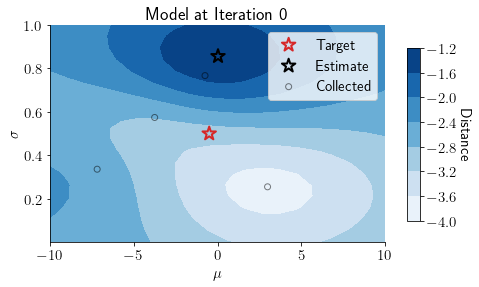

In [10]:
# random iteration
optim.save()
C0 = np.load('../data/0/new_x.npy')
sim.process_batch(C0, '../data/0.xlsx')
optim.update('../data/0.xlsx')
optim.save()
optim.get_current_best()
fig, ax = plt.subplots()
plot_contour(optim, ax)
ax.set_title('Model at Iteration 0')

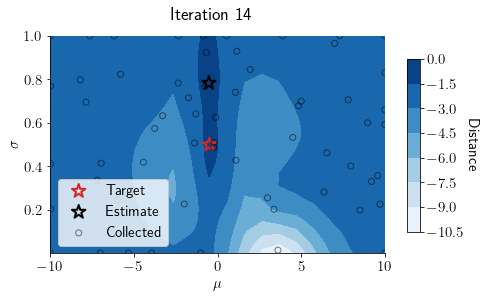

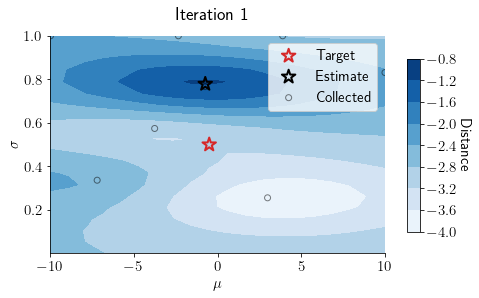

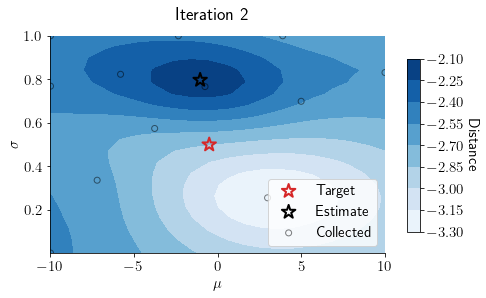

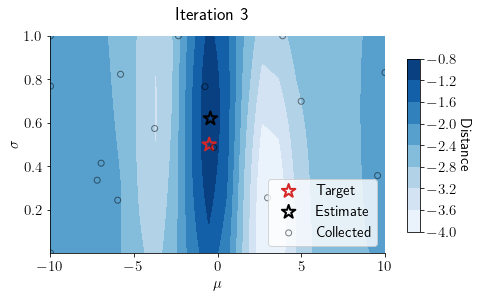

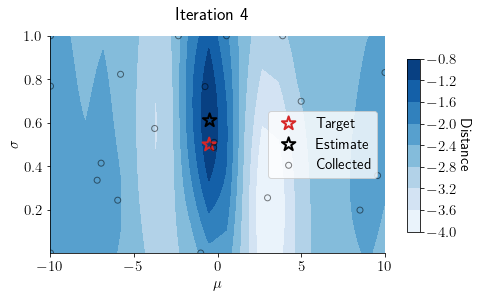

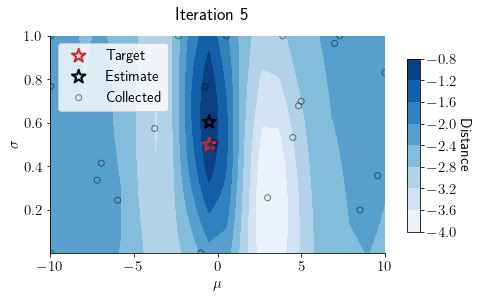

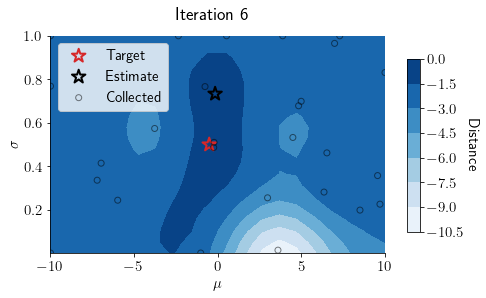

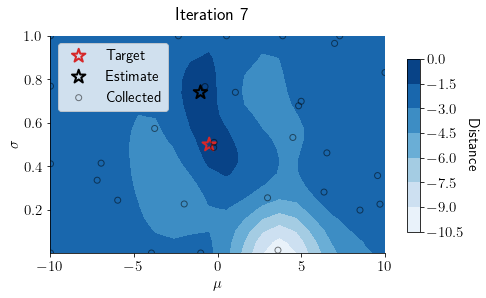

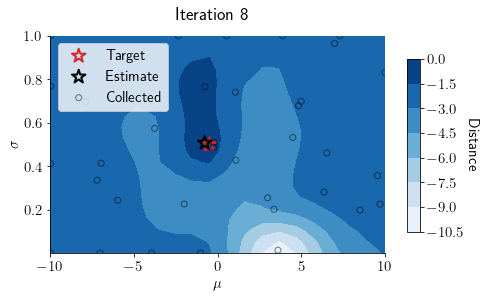

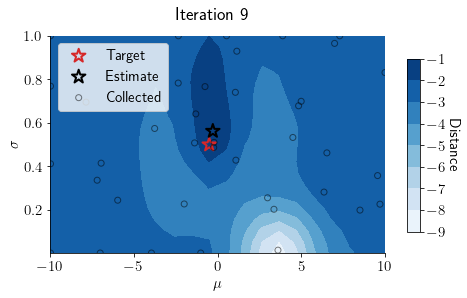

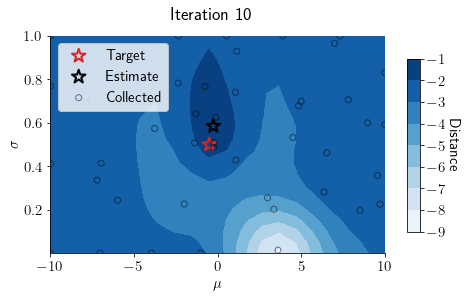

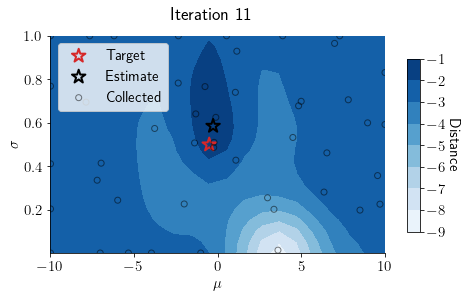

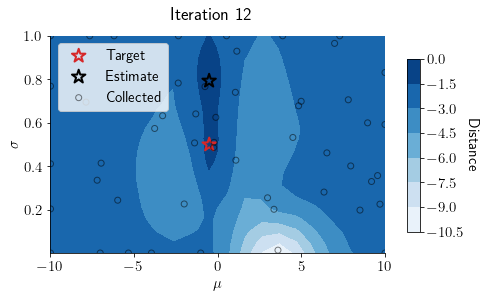

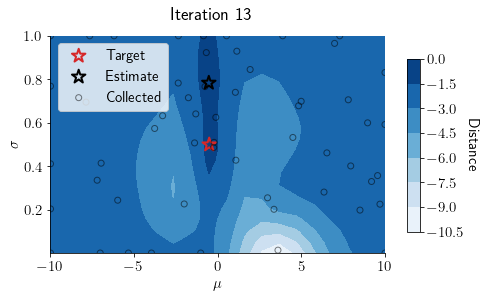

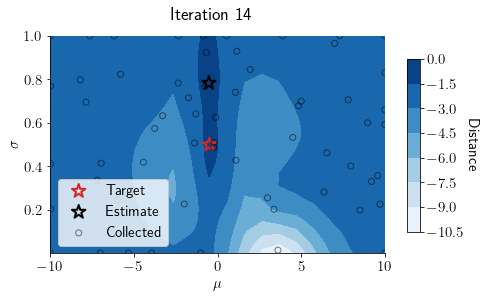

In [11]:
from IPython.display import display, clear_output

for i in range(1,15):
    # iteration i selection
    optim.suggest_next()
    optim.save()
    # simulate iteration i new_x 
    Ci = np.load('../data/%d/new_x.npy'%i)
    sim.process_batch(Ci, '../data/%d.xlsx'%i)
    optim.update('../data/%d.xlsx'%i)
    optim.save()
    optim.get_current_best()
    fig, ax = plt.subplots()
    plot_contour(optim, ax)
    fig.suptitle('Iteration %d'%(i))
    clear_output(wait=True)
    display(fig)
plt.show()

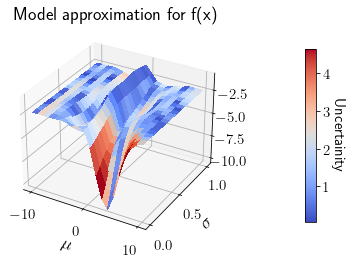

In [12]:
plot_surface(optim)

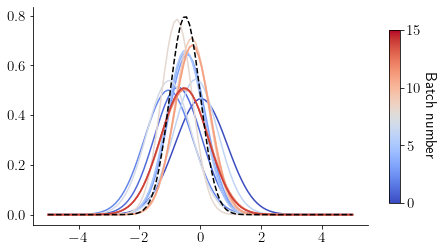

In [13]:
cmap = cm.get_cmap('coolwarm')
norm = Normalize(vmin=0, vmax = len(optim.best_loc))
fig, ax = plt.subplots()
for i, v in enumerate(torch.cat(optim.best_loc).numpy()):
    ax.plot(xt, sim.generate(*v), color=cmap(norm(i)))
ax.plot(xt, yt, ls='--', color='k')
cax = plt.axes([0.95, 0.2, 0.025, 0.6])        
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
cbar.ax.set_ylabel('Batch number', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
plt.show()